In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('kc_house_data-Copy1.csv')

In [3]:
# A data set contains 21613 obervations with 19 features plus house price. The names of the columns are given below.

# id - Unique ID for each home sold
# date - Date of the home sale
# price - Price of each home sold
# bedrooms - Number of bedrooms
# bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
# sqft_living - Square footage of the apartments interior living space
# sqft_lot - Square footage of the land space
# floors - Number of floors
# waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
# view - An index from 0 to 4 of how good the view of the property was 0 = No view, 1 = Fair 2 = Average, 3 = Good, 4 = Excellent
# condition - An index from 1 to 5 on the condition of the apartment,1 = Poor- Worn out, 2 = Fair- Badly worn, 3 = Average, 4 = Good, 5= Very Good
# grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
# sqft_above - The square footage of the interior housing space that is above ground level
# sqft_basement - The square footage of the interior housing space that is below ground level
# yr_built - The year the house was initially built
# yr_renovated - The year of the house’s last renovation
# zipcode - What zipcode area the house is in
# lat - Lattitude
# long - Longitude
# sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
# sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

In [4]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [6]:
# Deleting column 0 - id
df.drop(['id'], axis=1, inplace=True)

# Data description

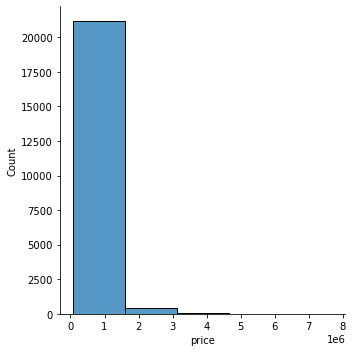

In [7]:
#1 price
sns.displot(df.price, bins=5)

In [8]:
df[df['price']>6450000] #list of rows with prices >75percentile

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
3914,20140611T000000,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
7252,20141013T000000,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
9254,20140919T000000,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


In [9]:
# droping three outliers
df.drop(df[df['price'] > 6450000].index, inplace=True)

<AxesSubplot:xlabel='date', ylabel='count'>

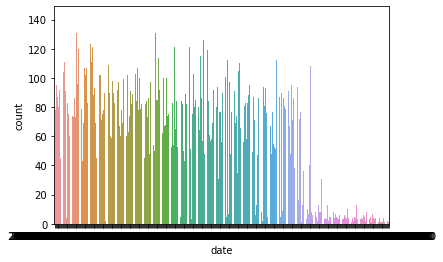

In [74]:
sns.countplot(x='date', data=df)

In [75]:
df['date'].min()

'20140502T000000'

In [76]:
df['date'].max()

'20150527T000000'

In [77]:
df[df['date']>'20150502T000000']

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
119,20150511T000000,535000.0,4,1.00,1610,2982,1.5,0,0,4,7,1610,0,1925,0,98144,47.5870,-122.294,1610,4040
142,20150508T000000,205000.0,3,1.00,1610,8579,1.0,0,0,4,7,1010,600,1962,0,98058,47.4563,-122.171,1610,8579
269,20150504T000000,2900000.0,4,3.25,5050,20100,1.5,0,2,3,11,4750,300,1982,2008,98004,47.6312,-122.223,3890,20060
278,20150505T000000,455000.0,4,2.50,2210,49375,1.0,0,0,3,8,2210,0,1997,0,98038,47.3828,-122.071,2670,49385
279,20150505T000000,405000.0,3,1.75,2390,6000,1.0,0,0,3,6,1240,1150,1908,0,98118,47.5362,-122.268,2020,6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21468,20150508T000000,649500.0,4,3.00,3150,6599,2.0,0,0,3,9,3150,0,2008,0,98056,47.5279,-122.199,2680,9430
21495,20150504T000000,534950.0,5,2.50,3220,10572,2.0,0,0,3,8,3220,0,2006,0,98019,47.7268,-121.957,2890,9090
21523,20150507T000000,579950.0,4,2.75,2460,8643,2.0,0,0,3,9,2460,0,2011,0,98059,47.4828,-122.133,3110,8626
21524,20150505T000000,861111.0,4,2.50,3650,7090,2.0,0,0,3,10,3650,0,2008,0,98074,47.6060,-122.052,3860,7272


In [11]:
#2-3 bedrooms, bathrooms
df[(df['bedrooms']==0) & (df['bathrooms']==0)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,20140612T000000,1095000.0,0,0.0,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
3119,20150205T000000,380000.0,0,0.0,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
6994,20140624T000000,1295650.0,0,0.0,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
9773,20150429T000000,355000.0,0,0.0,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
9854,20141223T000000,235000.0,0,0.0,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
14423,20150413T000000,139950.0,0,0.0,844,4269,1.0,0,0,4,7,844,0,1913,0,98001,47.2781,-122.250,1380,9600
19452,20140926T000000,142000.0,0,0.0,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850


In [12]:
#2 bedrooms
df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1600
6      270
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

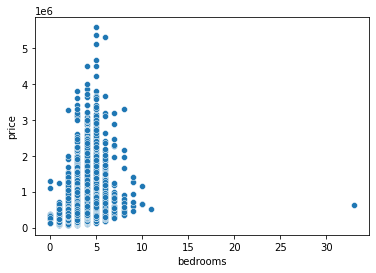

In [13]:
sns.scatterplot(x='bedrooms', y='price', data=df)
plt.show()

In [14]:
from numpy.lib.function_base import average
df.groupby('bedrooms').agg(
    {
        'price':[min, average, max],
        'sqft_living':[min, average, max],
        'bathrooms': [average]
    })

price                          sqft_living                      \
               min       average        max         min      average    max   
bedrooms                                                                      
0         139950.0  4.095038e+05  1295650.0         290  1707.846154   4810   
1          75000.0  3.176429e+05  1247000.0         370   884.613065   3000   
2          78000.0  4.013727e+05  3278000.0         440  1239.752899   6840   
3          82000.0  4.662321e+05  3800000.0         490  1805.837235   6400   
4         100000.0  6.354195e+05  4489000.0         800  2554.649666   7850   
5         133000.0  7.826774e+05  5570000.0        1120  3043.175000   9640   
6         175000.0  7.776171e+05  5300000.0        1370  3227.411111   7390   
7         280000.0  9.511847e+05  3200000.0        1940  3974.210526  13540   
8         340000.0  1.105077e+06  3300000.0        2280  3800.000000   7710   
9         450000.0  8.939998e+05  1400000.0        2820  3775.000000   4620   
10        650000.0  8.193333e+05  1148000.0        2920  3706.666667   4590   
11        520000.0  5.200000e+05   520000.0        3000  3000.000000   3000   
33        640000.0  6.400000e+05   640000.0        1620  1620.000000   1620   

         bathrooms  
           average  
bedrooms            
0         0.826923  
1         1.066583  
2         1.401721  
3         1.968394  
4         2.436428  
5         2.777500  
6         3.032407  
7         3.651316  
8         3.557692  
9         4.416667  
10        3.416667  
11        3.000000  
33        1.750000

In [15]:
# 33 bedrooms is a mistake, I'm changing it into 3:
df.loc[15870,'bedrooms']=3

In [16]:
df[df['bedrooms']==0].sort_values('price')

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
14423,20150413T000000,139950.0,0,0.00,844,4269,1.0,0,0,4,7,844,0,1913,0,98001,47.2781,-122.250,1380,9600
19452,20140926T000000,142000.0,0,0.00,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
4868,20141002T000000,228000.0,0,1.00,390,5900,1.0,0,0,2,4,390,0,1953,0,98118,47.5260,-122.261,2170,6000
9854,20141223T000000,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
8484,20140925T000000,240000.0,0,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685
18379,20141029T000000,265000.0,0,0.75,384,213444,1.0,0,0,3,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341
3467,20140805T000000,288000.0,0,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
12653,20150218T000000,320000.0,0,2.50,1490,7111,2.0,0,0,3,7,1490,0,1999,0,98065,47.5261,-121.826,1500,4675
8477,20141117T000000,339950.0,0,2.50,2290,8319,2.0,0,0,3,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
9773,20150429T000000,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050


In [17]:
# 0 bedrooms is a mistake, I'm changing it into 7 (where price > 1.000.000):
df["bedrooms"] = np.where( ((df["bedrooms"] == 0) & (df["price"] > 1000000)), 7, df["bedrooms"])
# changing into 2 (where price >= 320.000):
df["bedrooms"] = np.where( ((df["bedrooms"] == 0) & (df["price"] >= 320000)), 2, df["bedrooms"])
# changing into 1 (where price > 320.000):
df["bedrooms"] = np.where( ((df["bedrooms"] == 0) & (df["price"] < 320000)), 1, df["bedrooms"])

In [18]:
df['bedrooms'].value_counts()

3     9825
4     6882
2     2764
5     1600
6      270
1      206
7       40
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

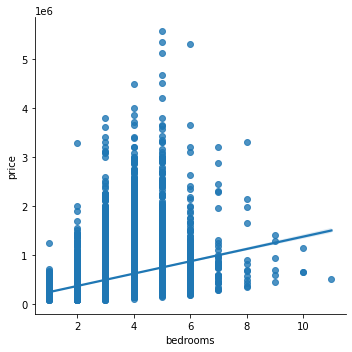

In [19]:
sns.lmplot(x='bedrooms', y='price', data=df)

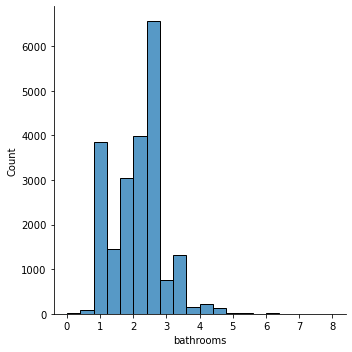

In [20]:
#3 bathrooms
sns.displot(df.bathrooms, bins=20)

In [21]:
df['bathrooms'].value_counts()

2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50      99
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
6.25       2
6.50       2
7.50       1
8.00       1
Name: bathrooms, dtype: int64

In [22]:
df[df['bathrooms']<0.5].sort_values('price')

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1149,20150217T000000,75000.0,1,0.0,670,43377,1.0,0,0,3,3,670,0,1966,0,98022,47.2638,-121.906,1160,42882
14423,20150413T000000,139950.0,1,0.0,844,4269,1.0,0,0,4,7,844,0,1913,0,98001,47.2781,-122.250,1380,9600
19452,20140926T000000,142000.0,1,0.0,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
9854,20141223T000000,235000.0,1,0.0,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
5832,20141104T000000,280000.0,1,0.0,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549
9773,20150429T000000,355000.0,2,0.0,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
3119,20150205T000000,380000.0,2,0.0,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
10481,20140918T000000,484000.0,1,0.0,690,23244,1.0,0,0,4,7,690,0,1948,0,98053,47.6429,-121.955,1690,19290
875,20140612T000000,1095000.0,7,0.0,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
6994,20140624T000000,1295650.0,7,0.0,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061


In [23]:
df.groupby('bathrooms').agg(
    {
        'price':[min, average, max],
        'sqft_living':[min, average, max]
    })

price                          sqft_living                     
                 min       average        max         min       average    max
bathrooms                                                                     
0.00         75000.0  4.481600e+05  1295650.0         290   1636.800000   4810
0.50        109000.0  2.373750e+05   312500.0         580   1235.000000   2300
0.75         80000.0  2.945209e+05   785000.0         370    896.611111   2510
1.00         78000.0  3.470412e+05  1300000.0         390   1181.123313   3410
1.25        275000.0  6.212167e+05  1388000.0         860   1525.555556   2400
1.50        107000.0  4.093222e+05  1500000.0         680   1544.630014   3520
1.75        115000.0  4.548961e+05  3278000.0         590   1787.202428   6840
2.00        115000.0  4.578897e+05  2200000.0         720   1796.669430   5461
2.25        160000.0  5.336768e+05  2400000.0         850   2097.700537   4910
2.50        153503.0  5.535965e+05  3070000.0         750   2377.901115   5760
2.75        183750.0  6.602304e+05  2700000.0         730   2669.998312   5700
3.00        154000.0  7.084152e+05  4489000.0        1160   2736.035857   6430
3.25        176000.0  9.703398e+05  3640900.0        1210   3223.940577   7420
3.50        216650.0  9.319331e+05  3710000.0        1130   3411.303694   7350
3.75        255000.0  1.197217e+06  3650000.0        1580   3779.741935   7620
4.00        265000.0  1.267709e+06  3400000.0        1390   4071.867647   7850
4.25        490000.0  1.525774e+06  3850000.0        1960   4609.329114   6980
4.50        290000.0  1.275753e+06  3567000.0        2120   4349.030303   6640
4.75        480000.0  2.021304e+06  3650000.0        3700   5275.652174   7880
5.00        343000.0  1.673492e+06  5350000.0        2732   4851.857143   8000
5.25        300000.0  1.817177e+06  5110800.0        2860   5016.153846   8010
5.50        925000.0  2.522300e+06  4500000.0        5060   6506.000000   7400
5.75        540000.0  2.492500e+06  5570000.0        3700   6962.500000   9200
6.00        900000.0  2.946833e+06  5300000.0        4340   6443.333333   7440
6.25       2888000.0  3.094000e+06  3300000.0        8020   8345.000000   8670
6.50       1180000.0  1.709445e+06  2238890.0        6260   6765.000000   7270
6.75        800000.0  2.734000e+06  4668000.0        7480   8560.000000   9640
7.50        450000.0  4.500000e+05   450000.0        4050   4050.000000   4050
8.00       2280000.0  2.280000e+06  2280000.0       13540  13540.000000  13540

In [24]:
# 0 bathrooms is a mistake, I'm changing it into 4 (where price > 1.000.000):
df["bathrooms"] = np.where( ((df["bathrooms"] == 0) & (df["price"] > 1000000)), 4, df["bathrooms"])
# changing into 0.75 (where sqfl_living < 1.000):
df["bathrooms"] = np.where( ((df["bathrooms"] == 0) & (df["sqft_living"] < 1000)), 0.75, df["bathrooms"])
# changing into 1 for the rest:
df["bathrooms"] = np.where(df["bathrooms"] == 0, 1, df["bathrooms"])

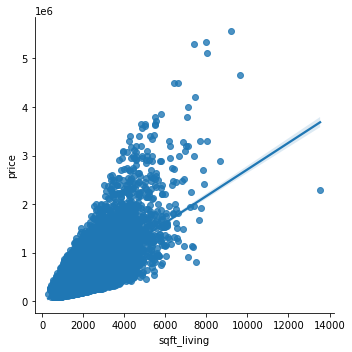

In [25]:
#4 sqft_living
sns.lmplot(x='sqft_living', y='price', data=df)
plt.show()

In [28]:
# droping one outlier
df.drop(df[df['sqft_living'] > 10000].index, inplace=True)

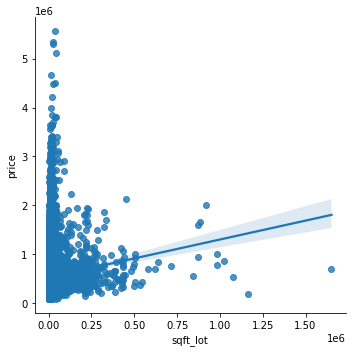

In [33]:
#5 sqft_lot
sns.lmplot(x='sqft_lot', y='price', data=df)
plt.show()

In [37]:
# droping one outlier
df.drop(df[df['sqft_lot'] > 1500000].index, inplace=True)

In [30]:
#6 floors
df['floors'].value_counts()

1.0    10680
2.0     8241
1.5     1910
3.0      613
2.5      161
3.5        8
Name: floors, dtype: int64

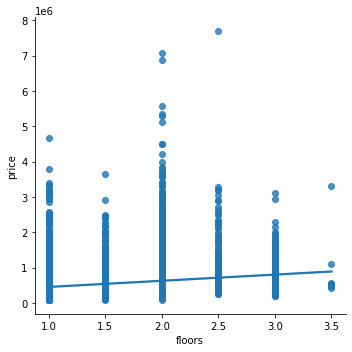

In [31]:
sns.lmplot(x='floors', y='price', data=df)
plt.show()

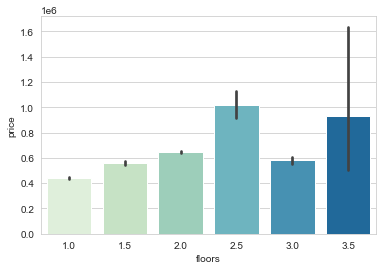

In [87]:
sns.set_style('whitegrid')
sns.barplot(x='floors', y='price', data=df, palette=sns.color_palette('GnBu', 6))
plt.show()

In [33]:
#7 waterfront: A variable for whether the apartment was overlooking the waterfront or not
df['waterfront'].value_counts()

0    21450
1      163
Name: waterfront, dtype: int64

In [32]:
#8 view: An index from 0 to 4 of how good the view of the property was:
# 0 = No view, 1 = Fair 2 = Average, 3 = Good, 4 = Excellent
df['view'].value_counts()

0    19489
2      963
3      510
1      332
4      319
Name: view, dtype: int64

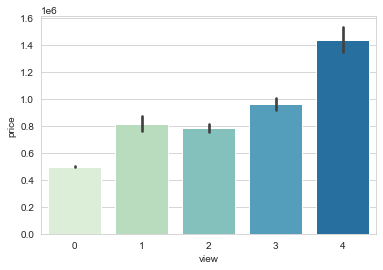

In [88]:
sns.barplot(x='view', y='price', data=df, palette=sns.color_palette('GnBu', 5))
plt.show()

In [34]:
#9 condition - An index from 1 to 5 on the condition of the apartment:
# 1 = Poor- Worn out, 2 = Fair- Badly worn, 3 = Average, 4 = Good, 5= Very Good
df['condition'].value_counts()

3    14031
4     5679
5     1701
2      172
1       30
Name: condition, dtype: int64

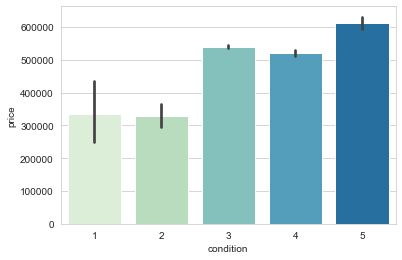

In [89]:
sns.barplot(x='condition', y='price', data=df, palette=sns.color_palette('GnBu', 5))
plt.show()

In [36]:
df.groupby('condition').agg(
    {
        'price':[min, average, max],
    })

price                          
                min        average        max
condition                                    
1           78000.0  334431.666667  1500000.0
2           80000.0  327287.145349  2555000.0
3           75000.0  542012.578148  7062500.0
4           89000.0  521200.390033  7700000.0
5          110000.0  612418.089359  3650000.0

In [37]:
#10 grade - An index from 1 to 13, where:
# 1-3 falls short of building construction and design, 
# 7 has an average level of construction and design,
# 11-13 have a high quality level of construction and design.
df['grade'].value_counts()

7     8981
8     6068
9     2615
6     2038
10    1134
11     399
5      242
12      90
4       29
13      13
3        3
1        1
Name: grade, dtype: int64

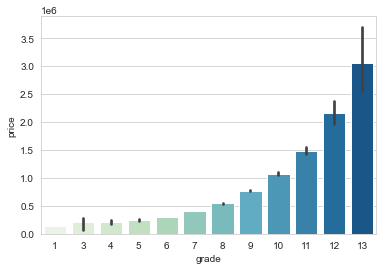

In [90]:
sns.barplot(x='grade', y='price', data=df, palette=sns.color_palette('GnBu', 12))
plt.show()

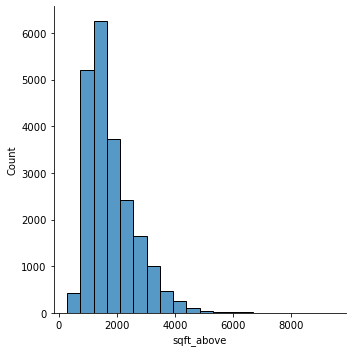

In [38]:
#11 sqft_above: the square footage of the interior housing space that is above ground level
sns.displot(df.sqft_above, bins=20)
plt.show()

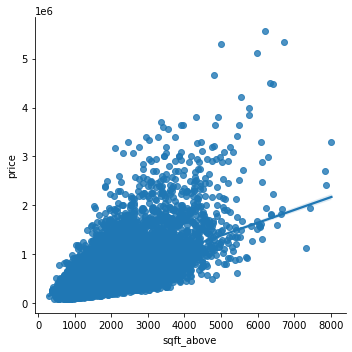

In [40]:
sns.lmplot(x='sqft_above', y='price', data=df)
plt.show()

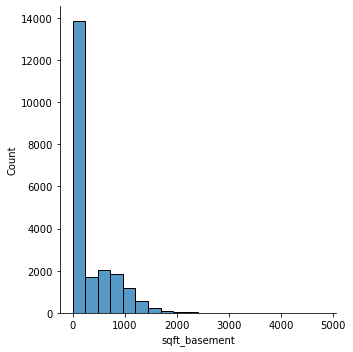

In [39]:
#12 sqft_basement: The square footage of the interior housing space that is below ground level
sns.displot(df.sqft_basement, bins=20)
plt.show()

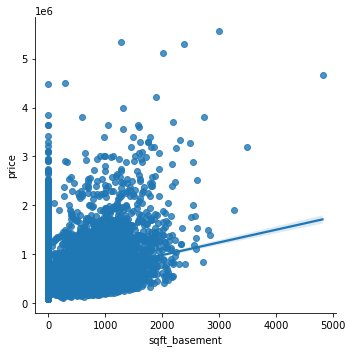

In [39]:
sns.lmplot(x='sqft_basement', y='price', data=df)
plt.show()

In [41]:
# droping one outlier
df.drop(df[df['sqft_basement'] > 4500].index, inplace=True)

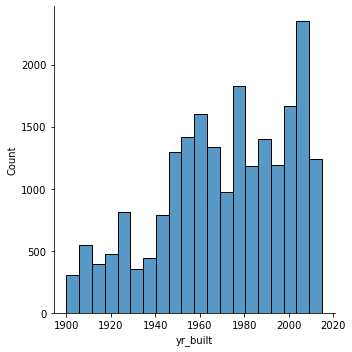

In [43]:
#14 yr_built: The year the house was initially built
sns.displot(df.yr_built, bins=20)
plt.show()

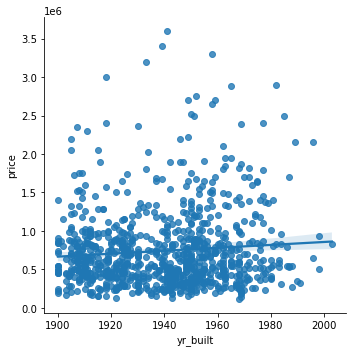

In [56]:
sns.lmplot(x='yr_built', y='price', data=df_ren)

In [45]:
#15 yr_renovated
df['yr_renovated'].value_counts()

0       20696
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

In [53]:
df_ren = df[(df['yr_renovated'] > 0)]

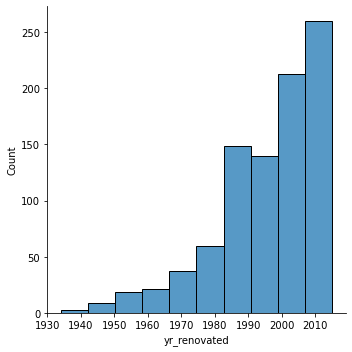

In [47]:
sns.displot(df_ren.yr_renovated, bins=10)
plt.show()

In [57]:
df_ren['yr_ren_cat']=pd.cut(df_ren['yr_renovated'], bins=[0,1950,1975,2000,2025],
                       labels=['before 1950','between 1950-1975','between 1975-2000','after 2000'])

C:\Users\HP\AppData\Local\Temp\ipykernel_17704\3886683639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ren['yr_ren_cat']=pd.cut(df_ren['yr_renovated'], bins=[0,1950,1975,2000,2025],


In [58]:
df_ren['yr_ren_cat'].value_counts()

after 2000           421
between 1975-2000    395
between 1950-1975     83
before 1950           12
Name: yr_ren_cat, dtype: int64

In [59]:
df_ren.groupby('yr_ren_cat').agg(
    {
        'price':[min, average, max],
    })

price                          
                        min        average        max
yr_ren_cat                                           
before 1950        152275.0  385743.750000   565000.0
between 1950-1975  160000.0  503443.795181  2050000.0
between 1975-2000  135000.0  746374.701266  3300000.0
after 2000         110000.0  794116.783848  3600000.0

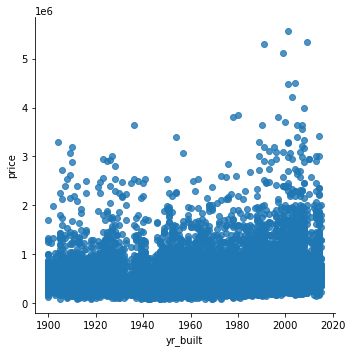

In [60]:
df_not_ren = df[(df['yr_renovated'] == 0)]
sns.lmplot(x='yr_built', y='price', data=df_not_ren)
plt.show()

In [61]:
df_not_ren['not_ren_built_yr']=pd.cut(df['yr_built'], bins=[0,1950,1975,2000,2025],
                       labels=['before 1950','between 1950-1975','between 1975-2000','after 2000'])

C:\Users\HP\AppData\Local\Temp\ipykernel_17704\646324575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_ren['not_ren_built_yr']=pd.cut(df['yr_built'], bins=[0,1950,1975,2000,2025],


In [62]:
df_not_ren['not_ren_built_yr'].value_counts()

between 1975-2000    6083
between 1950-1975    5497
before 1950          4577
after 2000           4539
Name: not_ren_built_yr, dtype: int64

In [63]:
df_not_ren.groupby('not_ren_built_yr').agg(
    {
        'price':[min, average, max],
    })

price                          
                        min        average        max
not_ren_built_yr                                     
before 1950         78000.0  520083.602141  3650000.0
between 1950-1975   75000.0  456459.765508  3395000.0
between 1975-2000  100000.0  541189.636035  5300000.0
after 2000         155000.0  613887.429169  5570000.0

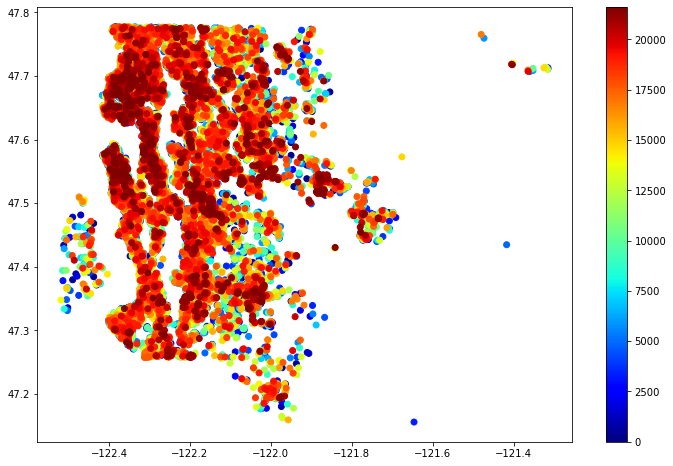

In [64]:
#16-17 longittude, lattitude
fig, ax=plt.subplots(figsize=(12,8))
sc=ax.scatter(df['long'], df['lat'], c=df['price'].index, cmap=plt.get_cmap('jet'))
plt.colorbar(sc)
plt.show()

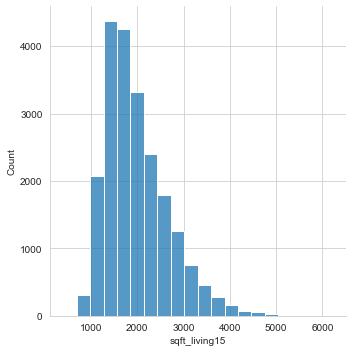

In [91]:
#18 sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
sns.displot(df.sqft_living15, bins=20)
plt.show()

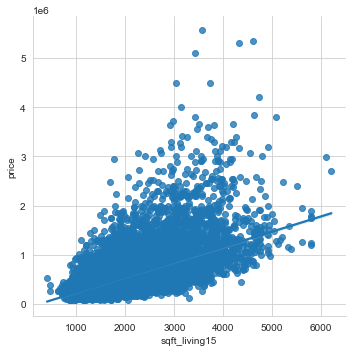

In [92]:
sns.lmplot(x='sqft_living15', y='price', data=df)
plt.show()

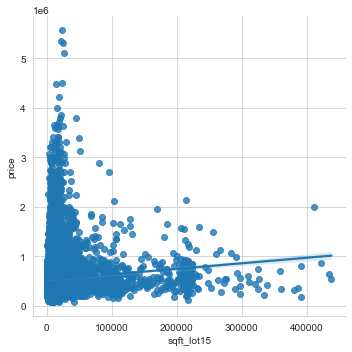

In [94]:
#19 sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors
sns.lmplot(x='sqft_lot15', y='price', data=df)
plt.show()

In [67]:
df[df['sqft_lot15']>600000].sort_values('price')

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9714,20150107T000000,937500.0,4,4.0,5545,871200,2.0,0,0,3,11,3605,1940,2003,0,98014,47.676,-121.882,3420,871200
20452,20150415T000000,1600000.0,4,5.5,6530,871200,2.0,0,2,3,11,6530,0,2008,0,98014,47.664,-121.878,1280,858132


In [68]:
# deleting three outliers
df.drop(df[df['sqft_lot15'] > 500000].index, inplace=True)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21604 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21604 non-null  object 
 1   price          21604 non-null  float64
 2   bedrooms       21604 non-null  int64  
 3   bathrooms      21604 non-null  float64
 4   sqft_living    21604 non-null  int64  
 5   sqft_lot       21604 non-null  int64  
 6   floors         21604 non-null  float64
 7   waterfront     21604 non-null  int64  
 8   view           21604 non-null  int64  
 9   condition      21604 non-null  int64  
 10  grade          21604 non-null  int64  
 11  sqft_above     21604 non-null  int64  
 12  sqft_basement  21604 non-null  int64  
 13  yr_built       21604 non-null  int64  
 14  yr_renovated   21604 non-null  int64  
 15  zipcode        21604 non-null  int64  
 16  lat            21604 non-null  float64
 17  long           21604 non-null  float64
 18  sqft_l

In [100]:
df.drop(['date','zipcode', 'lat', 'long'], axis=1, inplace=True)

KeyError: "['date', 'zipcode', 'lat', 'long'] not found in axis"

<AxesSubplot:>

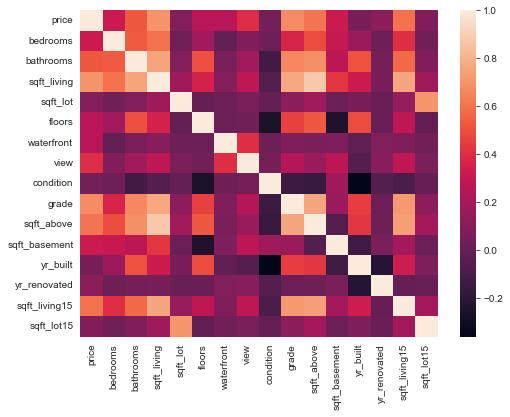

In [101]:
corr=df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21604 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21604 non-null  float64
 1   bedrooms       21604 non-null  int64  
 2   bathrooms      21604 non-null  float64
 3   sqft_living    21604 non-null  int64  
 4   sqft_lot       21604 non-null  int64  
 5   floors         21604 non-null  float64
 6   waterfront     21604 non-null  int64  
 7   view           21604 non-null  int64  
 8   condition      21604 non-null  int64  
 9   grade          21604 non-null  int64  
 10  sqft_above     21604 non-null  int64  
 11  sqft_basement  21604 non-null  int64  
 12  yr_built       21604 non-null  int64  
 13  yr_renovated   21604 non-null  int64  
 14  sqft_living15  21604 non-null  int64  
 15  sqft_lot15     21604 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.8 MB
